## 問題86

In [ ]:
# sklearn1.2からload_bostonは削除されたのでバージョンを下げる
!pip install scikit-learn==1.1.0
from sklearn.datasets import load_boston
import pandas as pd

In [ ]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
# colabで非同期処理を実行するために必要
import nest_asyncio
nest_asyncio.apply()

import stan

In [ ]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
stan_code = '''
data {
  int N;
  int M;
  vector[N] y;
  matrix[N, M] x;
  real beta;
}

parameters {
  vector[M] b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N)
    target += beta * normal_lpdf(y[n] | x[n] * b, sigma);
}

generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | x[n] * b, sigma);
}
'''

In [ ]:
def T_n(log_likelihood):
    return -np.mean(np.log(np.mean(np.exp(log_likelihood), axis=0)))

def V_n(log_likelihood):
    return np.mean(np.mean(log_likelihood**2, axis=0) - np.mean(log_likelihood, axis=0)**2)

def CV(log_likelihood, beta):
    t1 = np.log(np.mean(np.exp((1 - beta) * log_likelihood), axis=0))
    t2 = np.log(np.mean(np.exp(-beta * log_likelihood), axis=0))
    return -np.mean(t1 - t2)

def WAIC(log_likelihood, beta):
    return T_n(log_likelihood) + beta * V_n(log_likelihood)


In [ ]:
index = [0, 2, 4, 5, 6, 7, 9, 10, 11, 12]
df = boston_df.iloc[:, index]
N = df.shape[0]
K = len(index)
Y = np.array(boston.target)
X = df.to_numpy()

beta_seq = np.arange(0.1, 1.7, 0.1)
waic_values = []
cv_values = []

for beta in beta_seq:
    data_list = {'N': N, 'M': K, 'y': Y, 'x': X, 'beta': beta}
    stan_model = stan.build(stan_code, data=data_list, random_seed=1)
    fit = stan_model.sample()
    log_lik = fit['log_lik']
    waic_values.append(N * WAIC(log_lik, beta))
    cv_values.append(N * CV(log_lik, beta))


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000631 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000793 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations acc

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000158 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00019 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.9 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000191 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.91 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000168 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.68 seconds.
  Adjust your expectations acco

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000135 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000189 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.89 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00018 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.8 seconds.
  Adjust your expectations acco

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000171 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000153 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000169 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.69 seconds.
  Adjust your expectations ac

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000132 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000167 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.67 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000156 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000212 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.12 seconds.
  Adjust your expectations ac

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000119 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000186 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.86 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000162 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000166 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.66 seconds.
  Adjust your expectations ac

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  13% (1001/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000173 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.73 seconds.
  

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1501/8000)
Sampling:  20% (1601/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2401/8000)
Sampling:  34% (2701/8000)
Sampling:  35% (2800/8

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1601/8000)
Sampling:  21% (1701/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2301/8000)
Sampling:  38% (3001/8000)
Sampling:  38% (3002/8000)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1401/8000)
Sampling:  19% (1501/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2501/8000)
Sampling:  38% (3000/8

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1301/8000)
Sampling:  18% (1401/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2501/8000)
Sampling:  34% (2701/8000)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1601/8000)
Sampling:  21% (1701/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2301/8000)
Sampling:  30% (2401/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1401/8000)
Sampling:  19% (1501/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1501/8000)
Sampling:  20% (1601/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2401/8000)
Sampling:  33% (2601/8000)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1601/8000)
Sampling:  21% (1701/8000)
Sampling:  23% (1801/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1701/8000)
Sampling:  23% (1801/8000)
Sampling:  24% (1901/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2101/8000)
Sampling:  28% (2201/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8

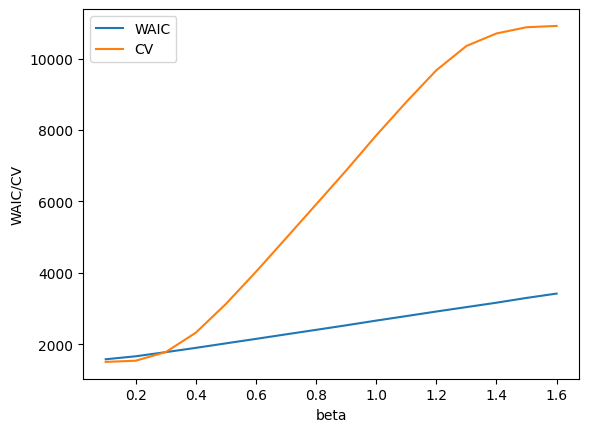

In [ ]:
plt.plot(beta_seq, waic_values, label='WAIC')
plt.plot(beta_seq, cv_values, label='CV')
plt.xlabel('beta')
plt.ylabel('WAIC/CV')
plt.legend()